In [1]:
import pandas as pd
import yfinance as yf
import os
from dotenv import load_dotenv
import fredapi
from fredapi import Fred
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=api_key)

In [3]:
housing_index = fred.get_series('CSUSHPISA', observation_start='1990-01-01', observation_end='2022-10-01')
housing_index = housing_index.dropna()
housing_index.tail()

2022-04-01    301.517
2022-05-01    305.293
2022-06-01    305.923
2022-07-01    304.544
2022-08-01    301.929
dtype: float64

<AxesSubplot:title={'center':'Case-Shiller National Home Price Index Historical'}, xlabel='Date', ylabel='Index'>

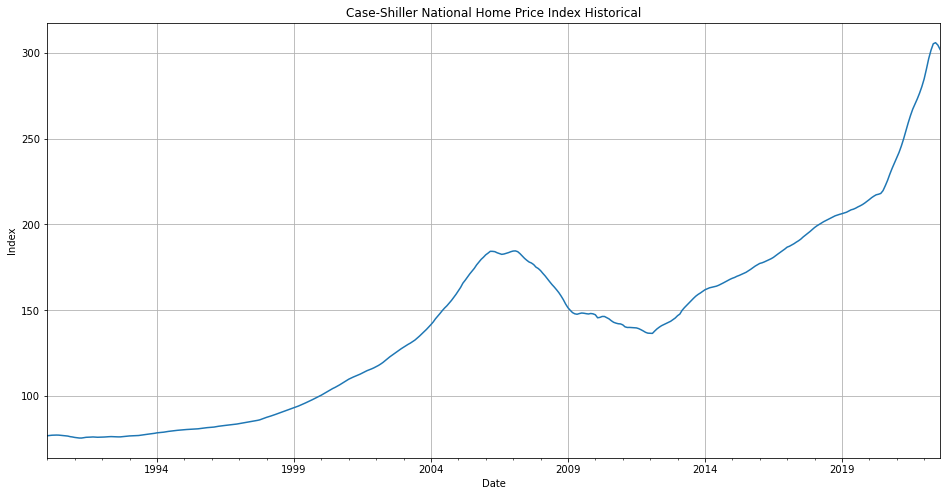

In [4]:
housing_index.plot(figsize=(16,8), title='Case-Shiller National Home Price Index Historical', grid=True, xlabel='Date', ylabel='Index')

In [6]:
# Pull S&P 500 historical data
ticker = "^GSPC" 
start= "1990-01-01" 
end= "2022-10-02"

sp_history = yf.download(ticker, start=start, end=end, progress=False)
sp_history = sp_history.asfreq(freq='D').ffill().dropna()
sp_history.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-26,3682.719971,3715.669922,3644.760010,3655.040039,3655.040039,4.886140e+09
2022-09-27,3686.439941,3717.530029,3623.290039,3647.290039,3647.290039,4.577740e+09
2022-09-28,3651.939941,3736.739990,3640.610107,3719.040039,3719.040039,4.684850e+09
2022-09-29,3687.010010,3687.010010,3610.399902,3640.469971,3640.469971,4.681810e+09
2022-09-30,3633.479980,3671.439941,3584.129883,3585.620117,3585.620117,5.645360e+09


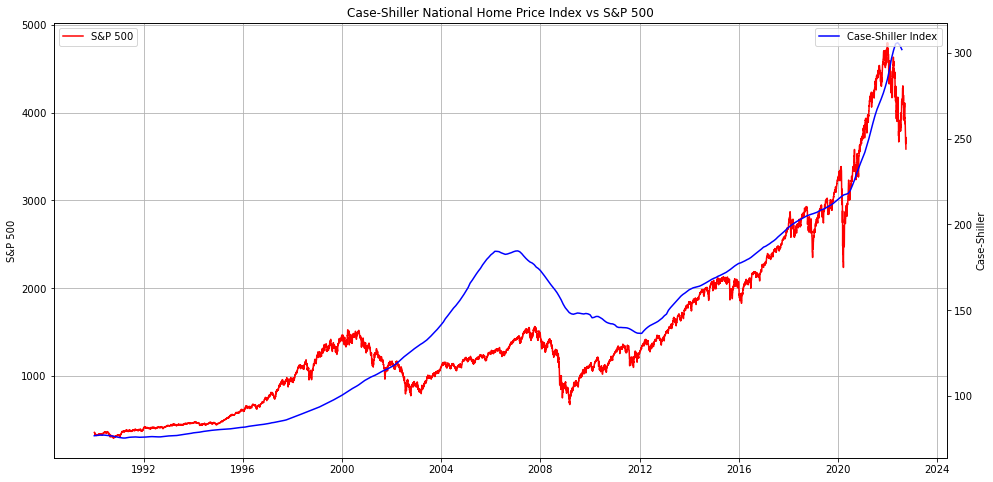

In [7]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(sp_history['Adj Close'], label ='S&P 500', color='r')
ax.set_ylabel('S&P 500')
plt.grid()
ax.legend(loc='upper left')

ax2 = ax.twinx()
plt.plot(housing_index, label='Case-Shiller Index', color='b')
ax.set_title('Case-Shiller National Home Price Index vs S&P 500')
ax2.set_ylabel('Case-Shiller')
ax2.legend(loc='upper right')

In [8]:
# Pull Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi = fred.get_series('CPIAUCSL', observation_start='2018-01-01')
cpi.tail()

2022-05-01    291.474
2022-06-01    295.328
2022-07-01    295.271
2022-08-01    295.620
2022-09-01    296.761
dtype: float64

In [9]:
cpi_percent_change = cpi.pct_change().dropna()
cpi_percent_change.tail()

2022-05-01    0.009738
2022-06-01    0.013222
2022-07-01   -0.000193
2022-08-01    0.001182
2022-09-01    0.003860
dtype: float64

In [10]:
# Concat Housing Index and CPI data, monthly freq
combined = pd.concat([housing_index, cpi, cpi_percent_change], axis=1).dropna()
combined['house_index'] = combined[0] * 1000 # convert to dollar value 
combined['cpi'] = combined[1]
combined['cpi_pct_chg'] = combined[2]
combined = combined.drop([combined.columns[0], combined.columns[1], combined.columns[2]], axis=1)
combined = combined['2018-01-01':].round(3)
combined.tail()

,house_index,cpi,cpi_pct_chg
2022-04-01,301517.0,288.663,0.003
2022-05-01,305293.0,291.474,0.010
2022-06-01,305923.0,295.328,0.013
2022-07-01,304544.0,295.271,-0.000
2022-08-01,301929.0,295.620,0.001


In [11]:
# Set reference CPI cost for comparison
ref_cpi_cost = cpi['2018-01-01'] 
ref_cpi_cost

248.743

In [12]:
# Adjust Case-Schiller Index for inflation
combined['house_index_inf_adj'] = (combined['house_index'] / combined['cpi']) * ref_cpi_cost
combined.tail()

,house_index,cpi,cpi_pct_chg,house_index_inf_adj
2022-04-01,301517.0,288.663,0.003,259819.384996
2022-05-01,305293.0,291.474,0.010,260536.091380
2022-06-01,305923.0,295.328,0.013,257666.746089
2022-07-01,304544.0,295.271,-0.000,256554.785915
2022-08-01,301929.0,295.620,0.001,254051.570418


<AxesSubplot:title={'center':'Case-Schiller Index Inflation Adjusted - period 01-01-2018 - 12-01-2021 (reference CPI 01-01-2018)'}, xlabel='Date', ylabel='Case-Schiller'>

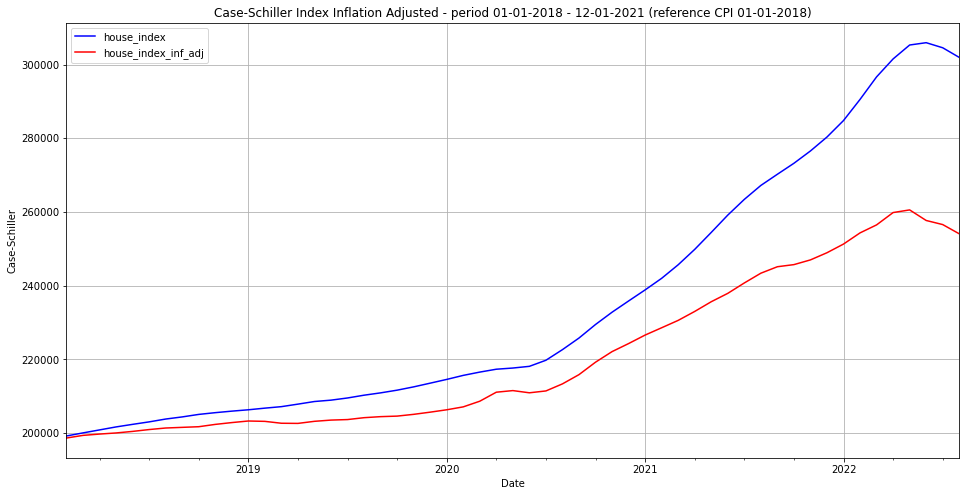

In [13]:
# Plot increase in housing prices for the specified time period
combined[['house_index', 'house_index_inf_adj']].plot(figsize=(16,8), title='Case-Schiller Index Inflation Adjusted - period 01-01-2018 - 12-01-2021 (reference CPI 01-01-2018)', grid=True, ylabel='Case-Schiller', xlabel='Date',color=('b','r'))